In [71]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy.optimize
from matplotlib import pyplot as plt

import cavity_qed_systems
import pulse
import cmps_utils
import tncontract as tn
import parameterized_pulse as ppulse

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


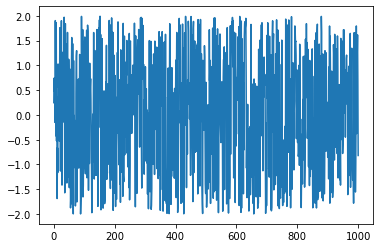

In [123]:
state = cavity_qed_systems.ModulatedTavisCumming(0.01, 2000, [0], 1.0, 1.0)
delta = ppulse.DirectParameterizedPulse(10, 1000, [2, -2])
plt.plot(delta.state())

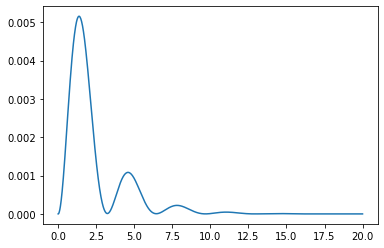

In [121]:
mps = state.get_mps([delta])
single_ph_proj = cmps_utils.compute_single_ph_proj(mps)
plt.plot(state.times, np.abs(single_ph_proj)**2)

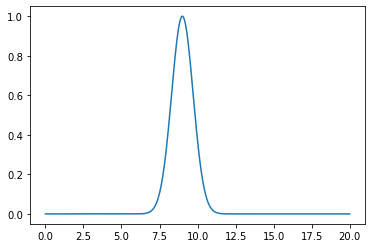

In [112]:
target_photon_pulse = pulse.GaussianPulse(1.0, 9.0, 1.0)
target_mps = cmps_utils.single_ph_state_as_mps(
    target_photon_pulse(state.times), bond_dim=state.sys_dim)

plt.plot(state.times, target_photon_pulse(state.times))

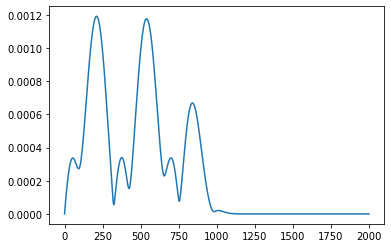

In [113]:
# Compute the gradient with respect to the pulse.
grad = state.get_inner_prod_gradient(
    target_mps, [delta])
plt.plot(np.abs(grad[0]))

In [124]:
def optimize_overlap(state, target_mps, pulse):
    """Right now we assume that there is only one pulse."""
    def _obj_fun(x):
        pulse.update(x)
        olap = np.abs(state.get_inner_product(target_mps, [pulse]))**2
        print("Current overlap = ", olap)
        return -olap
    
    def _gradient(x):
        pulse.update(x)
        inner_prod = state.get_inner_product(target_mps, [pulse])
        grad_inner_prod = state.get_inner_prod_gradient(
            target_mps, [pulse])[0]
        grad = -2 * pulse.get_gradient(state.times) @ np.real(
            grad_inner_prod * np.conj(inner_prod))
        return grad

    print(pulse.bounds())
    scipy.optimize.minimize(
        _obj_fun, pulse.state(), jac=_gradient, method="L-BFGS-B")

In [125]:
optimize_overlap(state, target_mps, delta)

[[ 2. -2.]
 [ 2. -2.]
 [ 2. -2.]
 ...
 [ 2. -2.]
 [ 2. -2.]
 [ 2. -2.]]
Current overlap =  0.011506058469297675


ValueError: failed to initialize intent(inout) array -- expected elsize=8 but got 16 -- input 'D' not compatible to 'd'

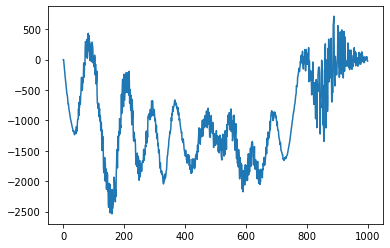

In [117]:
plt.plot(delta.state())